In [1]:
from landmark_detection.pipeline import Pipeline_Yolo_CVNet_SG
from benchmark.database import build_image_database
from landmark_detection.utils import show_image, show_bboxes
from benchmark.revisitop.evaluate import compute_map
from benchmark.revisitop.dataset import configdataset
from benchmark.evaluation import run_evaluation

import os
import pandas as pd
import pickle
import numpy as np

In [2]:
VERSION = 1

In [3]:
pipeline = Pipeline_Yolo_CVNet_SG(
        detector_file = "yolov8n-oiv7.pt",
        extractor_onnx_file = "cvnet-sg-v" + str(VERSION) + ".onnx",
        pipeline_onnx_file = "pipeline-yolo-cvnet-sg-v" + str(VERSION) + ".onnx",
        image_dim = (640, 640),
        allowed_classes = [41,68,70,74,87,95,113,144,150,158,164,165,193,205,212,224,257,
                                      298,310,335,351,354,390,393,401,403,439,442,457,466,489,510,512,
                                      514,524,530,531,543,546,554,565,573,580,587,588,591],
        score_thresh = 0.10,
        iou_thresh = 0.45,
        scales = [0.7071, 1.0, 1.4142],
        mean = [0.485, 0.456, 0.406],
        std  = [0.229, 0.224, 0.225],
        rgem_pr = 2.5,
        rgem_size = 5,
        gem_p = 4.6,
        sgem_ps = 10.0,
        sgem_infinity = False,
        eps = 1e-8  
)

Creando versión ONNX del detector
Ultralytics 8.3.146  Python-3.11.11 torch-2.7.0+cpu CPU (Intel Core(TM) i5-9300HF 2.40GHz)
YOLOv8n summary (fused): 72 layers, 3,492,527 parameters, 0 gradients, 10.5 GFLOPs

PyTorch: starting from 'C:\Users\rdiaz\Documents\GitHub\landmark-detection-with-retrieval\landmark_detection\models\yolov8n-oiv7.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 605, 8400) (6.9 MB)

ONNX: starting export with onnx 1.17.0 opset 16...
ONNX: slimming with onnxslim 0.1.54...
ONNX: export success  1.5s, saved as 'C:\Users\rdiaz\Documents\GitHub\landmark-detection-with-retrieval\landmark_detection\models\yolov8n-oiv7.onnx' (13.5 MB)

Export complete (2.1s)
Results saved to C:\Users\rdiaz\Documents\GitHub\landmark-detection-with-retrieval\landmark_detection\models
Predict:         yolo predict task=detect model=C:\Users\rdiaz\Documents\GitHub\landmark-detection-with-retrieval\landmark_detection\models\yolov8n-oiv7.onnx imgsz=640  
Validate:        yolo 

In [4]:
# Paths
CLASS_NAMES_PATH = os.path.join("oiv7.yaml")
PIPELINE_CONFIG_PATH = os.path.join("configs", "pipeline-yolo-cvnet-sg-v" + str(VERSION))
DATASETS_PATH = os.path.abspath("datasets")

# Dataset Oxford
ROXFORD5K_PATH = os.path.join(DATASETS_PATH, "roxford5k", "jpg")
ROXFORD5K_PKL = os.path.join(DATASETS_PATH, "roxford5k", "gnd_roxford5k.pkl")
ROXFORD5K_CSV = os.path.join(DATASETS_PATH, "roxford5k", "roxford5k_image_data.csv")
ROXFORD5K_DF = os.path.join(DATASETS_PATH, "roxford5k", "results", "df_roxford5k-v" + str(VERSION) + ".pkl")
ROXFORD5K_DESC = os.path.join(DATASETS_PATH, "roxford5k", "results", "desc_roxford5k-v" + str(VERSION) + ".pkl")

# Dataset Paris
RPARIS6K_PATH = os.path.join(DATASETS_PATH, "rparis6k", "jpg")
RPARIS6K_PKL = os.path.join(DATASETS_PATH, "rparis6k", "gnd_rparis6k.pkl")
RPARIS6K_CSV = os.path.join(DATASETS_PATH, "rparis6k", "rparis6k_image_data.csv")
RPARIS6K_DF = os.path.join(DATASETS_PATH, "rparis6k", "results", "df_rparis6k-v" + str(VERSION) + ".pkl")
RPARIS6K_DESC = os.path.join(DATASETS_PATH, "rparis6k", "results", "desc_rparis6k-v" + str(VERSION) + ".pkl")

In [5]:
TEST_IMG_PATH = os.path.join("test_images", "test.jpg")
final_boxes, final_scores, final_classes, descriptors, _ = pipeline.run(TEST_IMG_PATH)

Encontradas 5 cajas:
  Clase -1 full image @ 1.00 → [0.0,0.0,798.8,449.3]
  Clase 257 House @ 0.21 → [2.6,167.8,794.0,411.9]
  Clase 546 Tower @ 0.16 → [442.7,169.7,508.1,262.5]
  Clase 257 House @ 0.15 → [159.5,235.2,257.4,278.3]
  Clase 546 Tower @ 0.12 → [666.7,125.0,783.9,311.2]


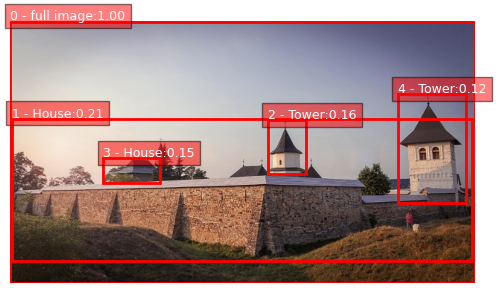

In [6]:
show_bboxes(TEST_IMG_PATH, CLASS_NAMES_PATH, final_boxes, final_classes, final_scores)

In [7]:
pipeline.to_json(PIPELINE_CONFIG_PATH)

In [8]:
# Build/load roxford5k dataset
df_result, descriptors_final = build_image_database(
    pipeline,
    image_folder = ROXFORD5K_PATH,
    df_pickle_path = ROXFORD5K_DF,
    descriptor_pickle_path = ROXFORD5K_DESC,
)

Procesando imágenes: 0it [00:00, ?it/s]


In [9]:
# Evaluate roxford5k
roxford5k_eval = run_evaluation(df_result, descriptors_final, 'roxford5k')

>> roxford5k: Evaluating test dataset...
>> roxford5k: Loading features...
>> roxford5k: Retrieval...
>> roxford5k: mAP E: 80.05, M: 64.04, H: 38.37
>> roxford5k: mP@k[ 1  5 10] E: [      97.06       86.99       82.98], M: [      97.14       88.67        84.1], H: [         80       64.14       53.29]


In [10]:
# Evaluate roxford5k
roxford5k_eval = run_evaluation(df_result, descriptors_final, 'roxford5k', use_bbox=True)

>> roxford5k: Evaluating test dataset...
>> roxford5k: Loading features...
>> roxford5k: Retrieval...
>> roxford5k: mAP E: 211.43, M: 189.44, H: 113.65
>> roxford5k: mP@k[ 1  5 10] E: [      95.59       88.24       81.47], M: [      95.71       93.14       86.86], H: [      82.86       76.29       66.14]


In [11]:
# Build/load rparis6k dataset
df_result, descriptors_final = build_image_database(
    pipeline,
    image_folder = RPARIS6K_PATH,
    df_pickle_path = RPARIS6K_DF,
    descriptor_pickle_path = RPARIS6K_DESC,
)

Procesando imágenes: 0it [00:00, ?it/s]


In [12]:
# Evaluate rparis6k
rparis6k_eval = run_evaluation(df_result, descriptors_final, 'rparis6k')

>> rparis6k: Evaluating test dataset...
>> rparis6k: Loading features...
>> rparis6k: Retrieval...
>> rparis6k: mAP E: 91.03, M: 80.66, H: 60.99
>> rparis6k: mP@k[ 1  5 10] E: [      97.14          96       94.57], M: [        100       98.86          98], H: [      95.71       93.71          91]


In [13]:
# Evaluate rparis6k
rparis6k_eval = run_evaluation(df_result, descriptors_final, 'rparis6k', use_bbox=True)

>> rparis6k: Evaluating test dataset...
>> rparis6k: Loading features...
>> rparis6k: Retrieval...
>> rparis6k: mAP E: 229.08, M: 211.97, H: 155.09
>> rparis6k: mP@k[ 1  5 10] E: [      97.14       96.57       95.86], M: [        100       98.86       98.71], H: [      97.14       95.71       95.14]
